In [2]:
import os
import sys
import yaml
import numpy as np
import pandas as pd
sys.path.append('/home/jovyan/work/PointCloudSegmentation/obstacle-detection/')
sys.path.append('/home/jovyan/work/PointCloudSegmentation/')
import pcl
import pcl.pcl_visualization
import pythreejs
import pyntcloud
import matplotlib.pyplot as plt
from importlib import reload  

from pipeline import pcl_pipeline
from pipeline import pcl_utils

In [3]:
with open('../config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [8]:
PATH_TO_DATASET = '/home/jovyan/work/dataset_sampling/rangenet_sampling/dataset/sequences/00/'
VELODYNE        = 'velodyne/'
LABELS          = 'labels/'
PREFIX_SCAN     = '000'

In [9]:
SCAN_NUM = '055'
scan = np.fromfile(PATH_TO_DATASET + VELODYNE +  PREFIX_SCAN + SCAN_NUM + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:, :3]

label = np.fromfile(PATH_TO_DATASET + LABELS + PREFIX_SCAN + SCAN_NUM + '.label', dtype=np.uint32)
label = label.reshape((-1))

In [10]:
# visualize point cloud
%matplotlib inline
test_cloud = pyntcloud.PyntCloud(pd.DataFrame(scan[:,:3], columns=['x','y','z']))
test_cloud.plot(backend='pythreejs', use_as_color='seg_id')

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.10233774781227112, 79.79987967014313, 3.26…

In [17]:
# Obstacles id -> name mapping
obstacle_lst = config['obstacles']
obstacle_lst

{10: 'car',
 11: 'bicycle',
 13: 'bus',
 15: 'motorcycle',
 16: 'on-rails',
 18: 'truck',
 20: 'other-vehicle',
 30: 'person',
 31: 'bicyclist',
 32: 'motorcyclist',
 252: 'moving-car',
 253: 'moving-bicyclist',
 254: 'moving-person',
 255: 'moving-motorcyclist',
 256: 'moving-on-rails',
 257: 'moving-bus',
 258: 'moving-truck',
 259: 'moving-other-vehicle'}

In [209]:
%time pcloud = pd.DataFrame(np.concatenate((scan, label.reshape(len(label), 1)), axis=1), columns=['x', 'y', 'z', 'seg_id'])

CPU times: user 13.7 ms, sys: 2.12 ms, total: 15.8 ms
Wall time: 15.9 ms


In [210]:
%%time
pcloud = common.roi_filter(pcloud,  min_x=params['roi_x_min'], max_x=params['roi_x_max'], 
                                                min_y=params['roi_y_min'], max_y=params['roi_y_max'],
                                                min_z=params['roi_z_min'], max_z=params['roi_z_max'], 
                                                verbose=False)

CPU times: user 53.6 ms, sys: 3.68 ms, total: 57.3 ms
Wall time: 57.3 ms


In [211]:
%time pcloud = common.obstacle_filter(pcloud, obstacle_lst, proc_labels=True, verbose=False)

CPU times: user 217 ms, sys: 2.92 ms, total: 220 ms
Wall time: 229 ms


In [10]:
from datetime import datetime
import time
from importlib import reload  
from pipeline import common

pcl_utils = reload(pcl_utils)

def pipeline_optimized_pcl(scan, label, obstacle_lst, verbose=False, exec_time=False, **params):
    # get segment id
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan,label.reshape(len(label), 1)), axis=1), 
                          columns=['x', 'y', 'z', 'seg_id'])
    
    pcloud = common.roi_filter(pcloud,  min_x=params['roi_x_min'], max_x=params['roi_x_max'], 
                                                min_y=params['roi_y_min'], max_y=params['roi_y_max'],
                                                min_z=params['roi_z_min'], max_z=params['roi_z_max'], 
                                                verbose=False)
    
    pcloud = common.obstacle_filter(pcloud, obstacle_lst, proc_labels=True, verbose=False)
    pcloud = pcloud.drop(['seg_id'], axis=1)
    pcloud = pcloud.drop(['camera'], axis=1)
    obstacle_time = datetime.now() - start_time
    
    if (len(pcloud.index) > 0):
        start_time = datetime.now()
        pcloud_pcl = pcl.PointCloud()
        pcloud_pcl.from_array(pcloud.to_numpy(dtype=np.float32))
        convert_time = datetime.now() - start_time

        # get voxel grid
        start_time = datetime.now()
        voxelgrid_id = pcl_utils.voxel_filter(pcloud_pcl, [params['x_voxels'],
                                                              params['y_voxels'],
                                                              params['z_voxels']])
        #voxelgrid_id = pcloud_pcl  
        voxel_time = datetime.now() - start_time

        # ROI filter
        start_time = datetime.now()
        pcloud_roi = pcl_utils.roi_filter(voxelgrid_id, [params['roi_x_min'], params['roi_x_max']], 
                                        [params['roi_y_min'], params['roi_y_max']], 
                                        [params['roi_z_min'], params['roi_z_max']],)
        roi_time = datetime.now() - start_time


        # get cluster
        start_time = datetime.now()
        cloud_obsts = pcloud_roi.extract([], negative = True)
        cluster_indices = pcl_utils.clustering(cloud_obsts, params['tol_distance'], params['min_cluster_size'], 150000)        
        clustering_time = datetime.now() - start_time

        # get bboxes
        start_time = datetime.now()
        box_min_max_list, box_coord_list = pcl_utils.get_cluster_box_list(
                                                    cluster_indices, cloud_obsts, 
                                                    radius_search=params['radius_search'], 
                                                    min_neighbors_in_radius=params['min_neighbors_in_radius'])
        bbox_time = datetime.now() - start_time
    else:
        box_min_max_list, box_coord_list = np.empty((0, 0)), np.empty((0, 0))
        roi_time, obstacle_time, voxel_time, clustering_time, bbox_time = 0, 0, 0, 0, 0
    
    if verbose:
        print('Execution time:')
        print('\n - ROI filtering: {:.5f} s'.format(roi_time.total_seconds()))
        print('\n - Filtering obstacles: {:.5f} s'.format(obstacle_time.total_seconds()))
        print('\n - Voxel grid: {:.5f} s'.format(voxel_time.total_seconds()))
        print('\n - Clustering: {:.5f} s'.format(clustering_time.total_seconds()))
        print('\n - Min-max cluster points: {:.5f} s \n'.format(bbox_time.total_seconds()))
        
    if exec_time:
        return box_min_max_list, box_coord_list, {'roi_time': roi_time.total_seconds(),
                                        'filter_obstacle_time': obstacle_time.total_seconds(),
                                        'voxel_grid_time': voxel_time.total_seconds(),
                                        'clustering_time': clustering_time.total_seconds(),
                                        'outlier_filter_bbox_time': bbox_time.total_seconds(),
                                        'convert_time' : convert_time.total_seconds()}
    else:
        return box_min_max_list, box_coord_list

In [20]:
from pipeline import pcl_pipeline
pcl_pipeline = reload(pcl_pipeline)

params = {'x_voxels'     : 0.3, 'y_voxels': 0.3, 'z_voxels': 0.3, 
          'roi_x_min'    : -30,   'roi_x_max'              : 30,
          'roi_y_min'    : -6, 'roi_y_max'                : 8,
          'roi_z_min'    : -3,  'roi_z_max'                : 3, 
          'tol_distance' : 0.7, 'min_cluster_size'         : 30,
          'radius_search': 0.8,   'min_neighbors_in_radius': 2}
%time box_min_max_list, box_coord_list, time = pcl_pipeline.pipeline_optimized_pcl(scan, label, obstacle_lst, verbose=True, exec_time=True, **params)

Execution time:

 - ROI filtering: 0.01300 s

 - Filtering obstacles: 0.29769 s

 - Voxel grid: 0.02831 s

 - Clustering: 0.35694 s

 - Min-max cluster points: 0.14928 s 

CPU times: user 330 ms, sys: 22 ms, total: 352 ms
Wall time: 849 ms


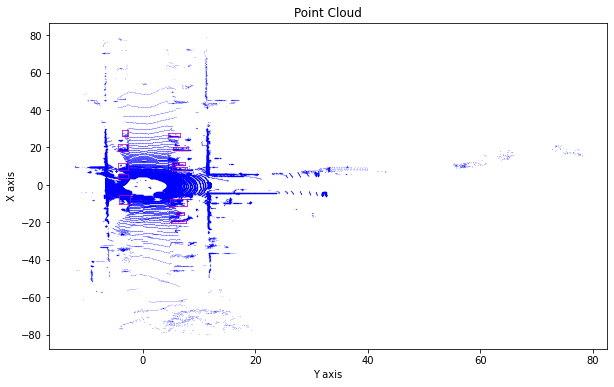

In [208]:
from scripts import draw

%matplotlib inline
f = plt.figure(figsize=(10, 6))
axes = [1,0]
# ax = f.add_subplot(111, projection='3d') 
ax = f.add_subplot(111) 
draw.draw_point_cloud(scan, ax, 'Point Cloud',axes=axes, 
                      axes_str = ['X', 'Y', 'Z'], )
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

In [204]:
params = {'x_voxels'     : 0.3, 'y_voxels': 0.3, 'z_voxels': 0.3, 
          'roi_x_min'    : -30,   'roi_x_max'              : 30,
          'roi_y_min'    : -6, 'roi_y_max'                : 8,
          'roi_z_min'    : -3,  'roi_z_max'                : 3, 
          'tol_distance' : 0.7, 'min_cluster_size'         : 30,
          'radius_search': 0.8,   'min_neighbors_in_radius': 2}

In [11]:
from scripts import test
import sklearn
test = reload(test)
range_params = params = { 'x_voxels'     : [0.3, 0.5, 0.8], 'y_voxels': [0.3, 0.5, 0.8], 'z_voxels': [0.3, 0.5, 0.8], 
                          'roi_x_min'    : [0],   'roi_x_max'                : [45],
                          'roi_y_min'    : [-15], 'roi_y_max'                : [15],
                          'roi_z_min'    : [-2],  'roi_z_max'                : [1], 
                          'tol_distance' : [0.5, 0.7, 0.9], 'min_cluster_size' : [20, 30, 40],
                          'radius_search': [0.5, 0.8, 1],   'min_neighbors_in_radius': [2, 4, 6]}
time_exec_lst = test.grid_search_optimization(scan, label, obstacle_lst, pipeline_optimized_pcl, range_params)

In [32]:
sorted_exec_dct = {k: v for k, v in sorted(time_exec_lst.items(), key=lambda item: item[1][0])}

In [12]:
for key in sorted_exec_dct:
    print(key,'Time and n clusters', sorted_exec_dct[key])

In [14]:
import glob
scan_lst = sorted(glob.glob(PATH_TO_DATASET + VELODYNE + "*.bin"))
labels_lst = sorted(glob.glob(PATH_TO_DATASET + LABELS + "*.label"))
assert len(scan_lst) == len(labels_lst)
print('READ OK, number of scans ', len(scan_lst))

READ OK, number of scans  459


In [15]:
params_ = {'x_voxels'     : 0.3, 'y_voxels': 0.3, 'z_voxels': 0.3, 
          'roi_x_min'    : 0,   'roi_x_max'              : 45,
          'roi_y_min'    : -15, 'roi_y_max'                : 15,
          'roi_z_min'    : -2,  'roi_z_max'                : 1, 
          'tol_distance' : 0.9, 'min_cluster_size'         : 20,
          'radius_search': 0.8,   'min_neighbors_in_radius': 6}

### Getting bounding boxes and grep statistics for sequence

In [44]:
%%time
pcl_utils = reload(pcl_utils)
pcl_pipeline = reload(pcl_pipeline)
test = reload(test)
n_scan = -1
write_path = PATH_TO_DATASET + 'clusters/'
# write_path = None
pipeline = pcl_pipeline.pipeline_optimized_pcl
bbox_dct, exec_time_dct, stats = test.get_bbox_and_stat_pcl(scan_lst[:n_scan], labels_lst[:n_scan], obstacle_lst,
                                                 pipeline, 
                                                 write_path=write_path, detailed=True, **params_)


CPU times: user 2min 18s, sys: 13.7 s, total: 2min 32s
Wall time: 4min 39s


In [45]:
steps = list(stats[0].keys())
steps_exec_time = []
for step in steps:
    steps_exec_time.append([stat[step] for stat in stats])

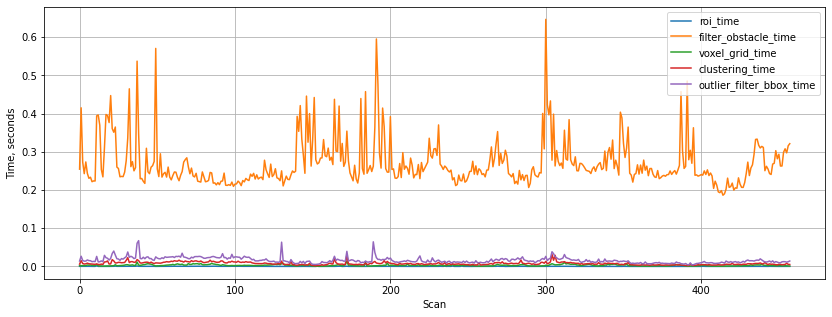

In [46]:
plt.figure(figsize=(14,5))
for i, step in enumerate(steps):
    plt.plot(steps_exec_time[i], label=step)
plt.legend(loc='best')
plt.xlabel('Scan')
plt.ylabel('Time, seconds')
plt.grid()
plt.show()

In [47]:
time_stat = list(exec_time_dct.values())
print('Min process time {} ms'.format(min(time_stat)))
print('Mean process time {} ms'.format(np.mean(time_stat)))
print('Max process time {} ms'.format(max(time_stat)))

Min process time 0.202401 ms
Mean process time 0.29730884716157197 ms
Max process time 0.690519 ms


In [37]:
ox = [int(x) for x in list(exec_time_dct.keys())]
oy = time_stat

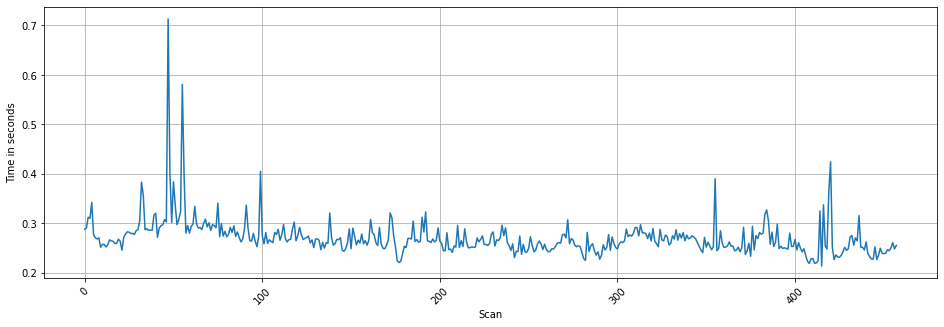

In [48]:
plt.figure(figsize=(16, 5))
plt.plot(ox, oy)
plt.xlabel('Scan')
plt.ylabel('Time in seconds')
plt.grid()
plt.xticks(rotation=45)
plt.show()

## Grep statistics of execution time

In [51]:
exec_lst = []
n_epoch = 3
for i in range(n_epoch):
    exec_time_dct = {}
    _, exec_time_dct, _ = test.get_bbox_and_stat_pcl(scan_lst[:n_scan], labels_lst[:n_scan], obstacle_lst,
                                                 pipeline, 
                                                 write_path=None, **params_)
    exec_lst.append(exec_time_dct)

In [ ]:
exec_time_dct

In [44]:
several_exec_time_lst = [] 
for epoch in exec_lst:
    several_exec_time_lst.append([tdelta for tdelta in epoch.values()])
several_exec_time_lst = list(zip(several_exec_time_lst[0],
                                 several_exec_time_lst[1],
                                 several_exec_time_lst[2]))

In [45]:
oy_mean = [np.mean(exec_times) for exec_times in several_exec_time_lst]
oy_min = [min(exec_times) for exec_times in several_exec_time_lst]
oy_max = [max(exec_times) for exec_times in several_exec_time_lst]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


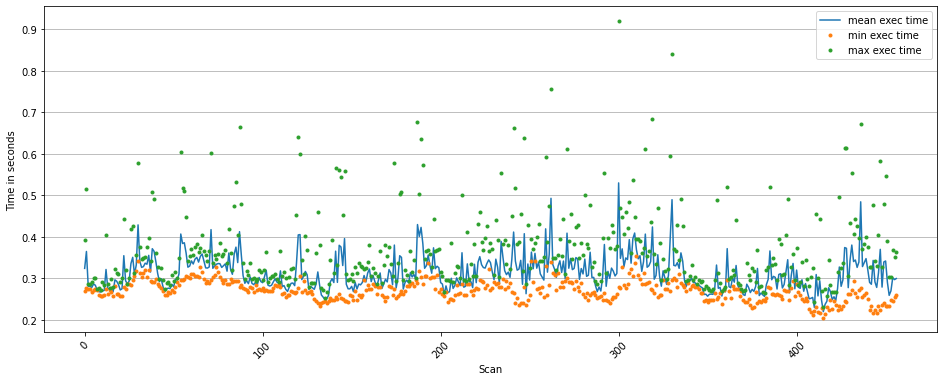

In [46]:
plt.figure(figsize=(16, 6))
plt.plot(ox, oy_mean, label='mean exec time')
plt.plot(ox, oy_min, '.', label='min exec time')
plt.plot(ox, oy_max, '.', label='max exec time')
ax = plt.axes()        
ax.yaxis.grid()
plt.xticks(rotation=45)
plt.xlabel('Scan')
plt.ylabel('Time in seconds')
plt.legend()
plt.show()